# Reasoning and Decision Making under Uncertainty
# Portfolio 2 - Sensor Fusion

**Name:  Aniket Dattatraya Kulkarni**

**Matriculation Number: 5123739**

**Email ID: aniketdattatraya.kulkarni@study.thws.de**

## Task P2.1: Kalman Filter

### Realize an implementation of the Kalman Filter in a programming language of your choice for a simulation of the ball-throwing example from the lecture slides. The task of your Kalman Filter is to estimate the position and velocity vector of the ball only from the observed erroneous positions over time.
Your implementation shall be flexible in the sense that it can handle the following variations:

Simulate the trajectory of a ball with the parameters launch position (especially the height above an imaginary ground), launch speed and launch angle of the ball.

Simulate the observation of the ball position (x, y as shown in the slides). The estimated ball position shall be subject to uncertainty and it shall be possible to parameterize this uncertainty. In addition, the time span between two observations shall be variable and the observations shall be able to drop out completely over a certain period of time.

The initial parameters of the Kalman Filter shall be adaptable.

The normally distributed noise on transition and observation should be adjustable. This means that the covariance matrices R and Q shall be set as a parameter in the Kalman Filter.

Launch Speed: 80 m/s
Launch Angle: 45.00 degrees
Launch Height: 0 m
Measurement Noise Std: 0.2 m
Dropout Probability: 0.05
Mean Squared Error: 3.095152935873398
Root Mean Squared Error: 1.7593046739758857


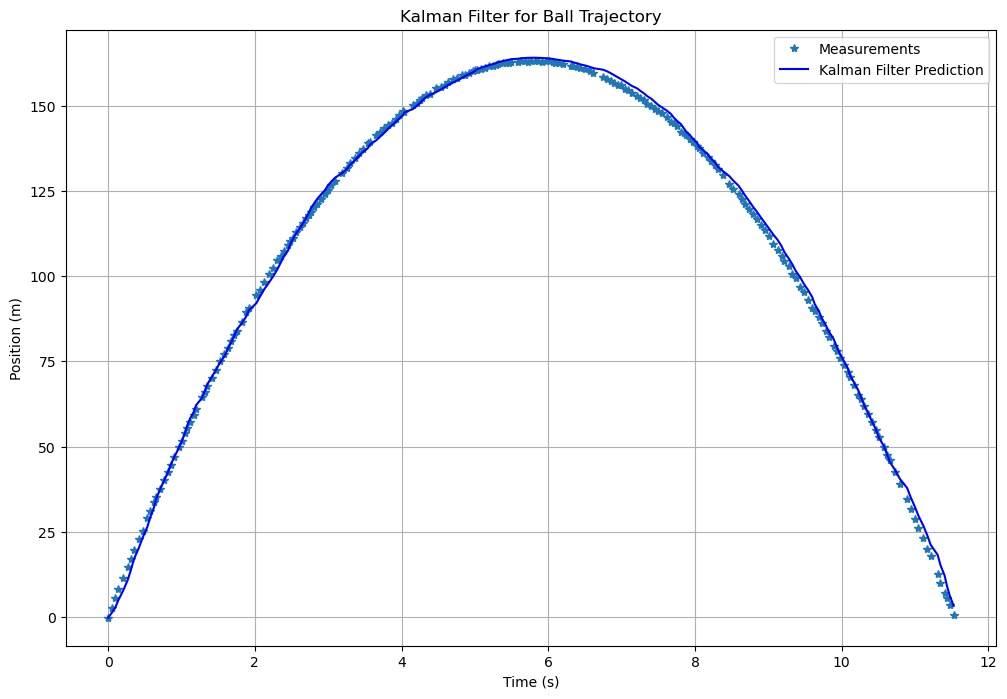

In [60]:
#Import Libraries and Configuration 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Configuration section for input parameters
config = {
    "simulation": {
        "dt": 0.05,  # Base time step (s)
        "total_time": 16,  # Total time of simulation (s)
        "launch_speed": 80,  # Initial speed (m/s)
        "launch_angle": 45,  # Launch angle (degrees)
        "launch_height": 0,  # Launch height (m)
        "measurement_noise_std": 0.2,  # Standard deviation of measurement noise (m)
        "std_acc": 0.1,  # Standard deviation of acceleration noise (m/s^2)
        "x_std_meas": 0.2,  # Standard deviation of measurement noise in x direction (m)
        "y_std_meas": 0.2,  # Standard deviation of measurement noise in y direction (m)
        "dropout_prob": 0.05,  # Probability of dropping an observation
        "variable_time_step_std": 0.01  # Standard deviation of variable time steps (s)
    },
    "kalman_filter": {
        "u": [0, -9.81],  # Control input (acceleration due to gravity) (m/s^2)
    }
}

# Extract parameters from the configuration
dt = config["simulation"]["dt"]
total_time = config["simulation"]["total_time"]
launch_speed = config["simulation"]["launch_speed"]
launch_angle = np.deg2rad(config["simulation"]["launch_angle"])  # Convert angle to radians
launch_height = config["simulation"]["launch_height"]
vel_x = launch_speed * np.cos(launch_angle)
vel_y = launch_speed * np.sin(launch_angle)
measurement_noise_std = config["simulation"]["measurement_noise_std"]
std_acc = config["simulation"]["std_acc"]
x_std_meas = config["simulation"]["x_std_meas"]
y_std_meas = config["simulation"]["y_std_meas"]
dropout_prob = config["simulation"]["dropout_prob"]
variable_time_step_std = config["simulation"]["variable_time_step_std"]
u = config["kalman_filter"]["u"]

# Kalman Filter Class
class KalmanFilter:
    def __init__(self, dt, u, std_acc, x_std_meas, y_std_meas):
        self.dt = dt
        self.u = np.array(u, dtype=float).reshape(2, 1)
        self.std_acc = std_acc
        self.x_std_meas = x_std_meas
        self.y_std_meas = y_std_meas

        # State vector [x, y, vx, vy]
        self.x = np.zeros((4, 1))
        
        # State transition matrix
        self.F = np.array([[1, 0, self.dt, 0],
                           [0, 1, 0, self.dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        
        # Control input matrix
        self.B = np.array([[0.5 * self.dt ** 2, 0],
                           [0, 0.5 * self.dt ** 2],
                           [self.dt, 0],
                           [0, self.dt]])
        
        # Measurement matrix
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])
        
        # Process noise covariance matrix
        self.Q = np.array([[self.dt ** 4 / 4, 0, self.dt ** 3 / 2, 0],
                           [0, self.dt ** 4 / 4, 0, self.dt ** 3 / 2],
                           [self.dt ** 3 / 2, 0, self.dt ** 2, 0],
                           [0, self.dt ** 3 / 2, 0, self.dt ** 2]]) * std_acc ** 2
        
        # Measurement noise covariance matrix
        self.R = np.array([[x_std_meas ** 2, 0],
                           [0, y_std_meas ** 2]])
        
        # Covariance matrix
        self.P = np.eye(4)

    def predict(self):
        # Predict the state and the state covariance
        self.x = np.dot(self.F, self.x) + np.dot(self.B, self.u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q

    def update(self, z):
        # Update the state with the measurement z
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        y = z.reshape(2, 1) - np.dot(self.H, self.x)
        self.x = self.x + np.dot(K, y)
        I = np.eye(4)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

    def simulate(self, z):
        # Simulate the Kalman Filter with the given measurements
        estimates = []
        for measurement in z:
            self.predict()
            self.update(measurement)
            estimates.append(self.x.copy())
        return np.array(estimates).squeeze()

# Generate the trajectory with noise and random dropouts
g = 9.81
tlist = []
t = 0
xlist = []
ylist = []

# Simulate the ball trajectory with variable time steps and dropouts
while t < total_time:
    x = vel_x * t
    y = launch_height + vel_y * t - 0.5 * g * t ** 2
    if y >= 0 and np.random.rand() > dropout_prob:
        xlist.append(x)
        ylist.append(y + np.random.normal(0, measurement_noise_std))
        tlist.append(t)
    t += dt + np.random.normal(0, variable_time_step_std)

# Combine the x and y positions into a single array for measurements
noisy_measurements = np.column_stack((xlist, ylist))

# Initialize the Kalman Filter
kf = KalmanFilter(dt, u, std_acc, x_std_meas, y_std_meas)

# Run the Kalman Filter
estimates = kf.simulate(noisy_measurements)

# Calculate RMSE and MSE
rmse = np.sqrt(mean_squared_error(ylist, estimates[:, 1]))
mse = mean_squared_error(ylist, estimates[:, 1])

# Print important information
print(f"Launch Speed: {launch_speed} m/s")
print(f"Launch Angle: {np.rad2deg(launch_angle):.2f} degrees")
print(f"Launch Height: {launch_height} m")
print(f"Measurement Noise Std: {measurement_noise_std} m")
print(f"Dropout Probability: {dropout_prob}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Plot results
plt.figure(figsize=(12, 8))

# Plot noisy measurements
plt.plot(tlist, ylist, '*', label='Measurements')

# Plot Kalman Filter predictions
plt.plot(tlist, estimates[:, 1], 'b-', label='Kalman Filter Prediction')

plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Kalman Filter for Ball Trajectory')
plt.legend()
plt.grid(True)
plt.show()
